Stats 147: Data Technologies for Data Scientists

This is the official demo for Daniel Neufeldt's final presentation about utilizing statsmodels on time series data. In this demo, we will specifically work with cleaning and decomposing our data and then implementing an ARIMA model forecast.

In [2]:
# import the correct libraries
import pandas as pd
import statsmodels
import numpy as np
import matplotlib.pyplot as plt

# import the libary that let's us decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose 

In [3]:
# load the data
data = pd.read_csv("AirPassengers.csv")
print(data.dtypes)
data.head()

Month          object
#Passengers     int64
dtype: object


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Our data is a Kaggle dataset that consists of # of passengers for an airline in a given month

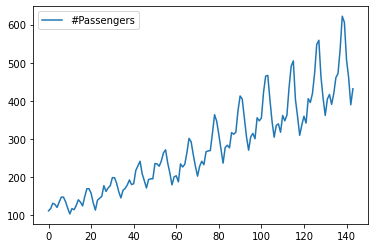

In [4]:
data.plot();

We can see clear patterns and a trend occuring. This is out of the scope of this presentation but because the variance of this time series gets increasingly larger, we must set the "model" argument in seasonal_decompose to "multiplicative" (if the variance was constant, we would set the argument to "additive")

<Figure size 1008x504 with 0 Axes>

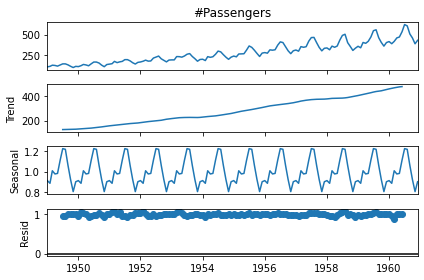

In [5]:
# Convert the 'Month' column to datetime format and set it as the index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(data['#Passengers'], model='multiplicative')

# Plot the decomposed components
plt.figure(figsize=(14, 7))
decomposition.plot()
plt.show()

This can be a bit hard to view. Let's try to look at the data more closely

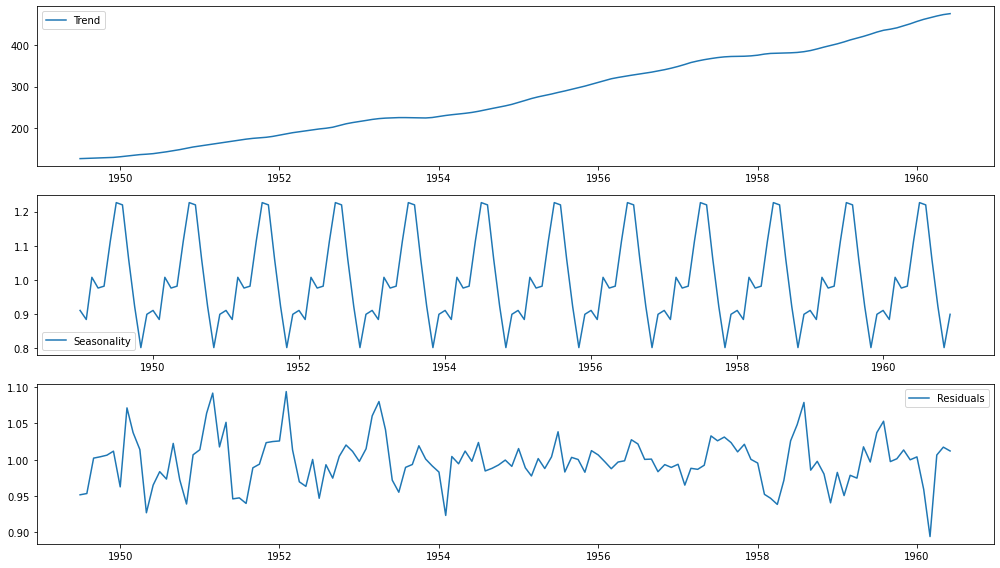

In [6]:
# Extracting the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting each component
plt.figure(figsize=(14, 8))

# Plot trend
plt.subplot(311)  # 3 rows, 1 column, 1st subplot
plt.plot(trend, label='Trend')
plt.legend(loc='best')

# Plot seasonal
plt.subplot(312)  # 3 rows, 1 column, 2nd subplot
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

# Plot residual
plt.subplot(313)  # 3 rows, 1 column, 3rd subplot
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Here, we can see that there is a strong trend going upwards. In addition to this, there is clear seasonality as there is a repeating pattern that occurs during the same time each year.

In [7]:
# we want to see if our data is stationary. An assumption of the ARIMA model is that the input data is stationary
# To test this, we can use a hypothesis test called the augmented Dicky-Fuller test, where the null
# hypothesis is that the time series is not stationary

from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test = adfuller(data['#Passengers'])

# Output the results
adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Used Lag': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4],
}

adf_result

{'Test Statistic': 0.8153688792060472,
 'p-value': 0.991880243437641,
 'Used Lag': 13,
 'Number of Observations Used': 130,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598}}

We can see that the p-value is much greater than 0.05. This means that our data is definitely not stationary. To fix this issue, we can do something called differencing our data. Differencing is subtracting the previous value from our current value. By doing this, we remove a lot of the correlation between points, resulting in a more stationary dataset

In [8]:
# Apply differencing to make the series stationary. Make sure to drop the NA values because the initial point
# cannot be differenced: y_0 - y_-1 does not work
data_diff = data['#Passengers'].diff().dropna()

# Perform ADF test again on the differenced data
adf_test_diff = adfuller(data_diff)

# Output the results for the differenced data
adf_result_diff = {
    'Test Statistic': adf_test_diff[0],
    'p-value': adf_test_diff[1],
    'Used Lag': adf_test_diff[2],
    'Number of Observations Used': adf_test_diff[3],
    'Critical Values': adf_test_diff[4],
}

adf_result_diff

{'Test Statistic': -2.8292668241700056,
 'p-value': 0.054213290283824704,
 'Used Lag': 12,
 'Number of Observations Used': 130,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598}}

In [9]:
data['#Passengers'].diff()

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
              ... 
1960-08-01   -16.0
1960-09-01   -98.0
1960-10-01   -47.0
1960-11-01   -71.0
1960-12-01    42.0
Name: #Passengers, Length: 144, dtype: float64

Here, we have a p-value of 0.054. This may be above the p-value threshold, but for the sake of simplicity I will say that this is good enough and we will move forward with this demo. Let's remove all observations from the year 1960 as that can be our testing data when we verify our ARIMA model.

In [24]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

train = data['#Passengers'][:'1959']
test = data['#Passengers']['1960':]
# Attempt to model with ARIMA on the differenced data (p=1, d=1, q=1) as a starting point
# p is the AR component. d is the differencing component (d=1 for us because we differenced data),
# and q is the MA component. We typically choose these values by analyzing an autocorrelation function
# but that is out of the scope of this demo. For simplicity, I will just select default values of (1, 1, 1)

# Choosing a basic ARIMA(1,1,1) model as a starting point
model = ARIMA(train, order=(1, 1, 1))
model_arima = model.fit()

# Summary of the model
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  132
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -625.518
Date:                Thu, 21 Mar 2024   AIC                           1257.035
Time:                        19:29:28   BIC                           1265.661
Sample:                    01-01-1949   HQIC                          1260.540
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5436      0.100     -5.443      0.000      -0.739      -0.348
ma.L1          0.9272      0.051     18.336      0.000       0.828       1.026
sigma2       816.5398     95.147      8.582      0.000     630.056    1003.024
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.57   Prob(JB):                         0.29
Heteroskedasticity (H):               6.76   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We would typically use AIC to determine if the model is good along with getting the testing RMSE.

In [11]:
prediction_period = 12 # we set this to 12 because we want to forecast the next 12 weeks
forecast = model_arima.get_forecast(steps = prediction_period) # this creates the forecast
forecast_index = pd.date_range(data.index[-1],
                               periods=prediction_period + 1, closed='right') # this sets up the index

forecast_mean = forecast.predicted_mean
forecast_mean_df = pd.DataFrame(forecast_mean, columns=[''])
forecast_mean

1960-01-01    433.451927
1960-02-01    417.984221
1960-03-01    426.393139
1960-04-01    421.821685
1960-05-01    424.306927
1960-06-01    422.955841
1960-07-01    423.690350
1960-08-01    423.291039
1960-09-01    423.508122
1960-10-01    423.390106
1960-11-01    423.454265
1960-12-01    423.419385
Freq: MS, Name: predicted_mean, dtype: float64

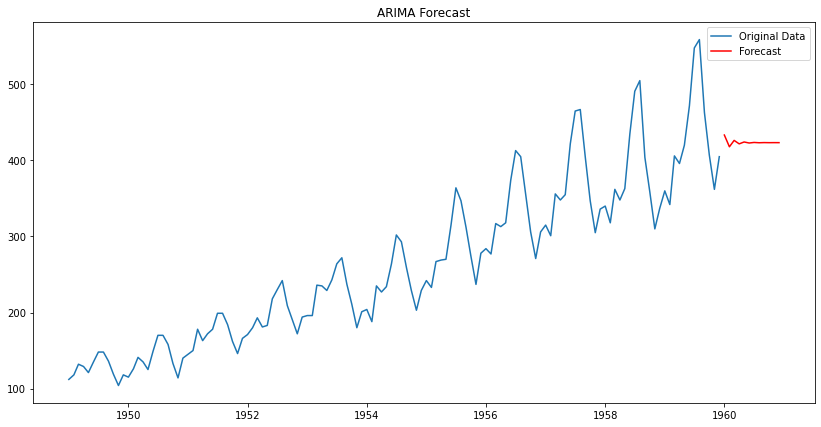

In [12]:
ts_data = pd.concat([train, forecast_mean])

plt.figure(figsize=(14, 7))
plt.plot(ts_data[:132], label='Original Data')
plt.plot(ts_data[132:], color='red', label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [13]:
# check the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test, forecast_mean)
rmse = sqrt(mse)
rmse

91.22883941049551

We can see that this isn't necessarily the greatest model in the world; however, this does give us a bit of a look into seeing data a bit differently and using new tools that aren't taught too widely in college during undergrad (I say this as there is only one time series class at UCLA and is offered once a year). For the people who want a further look into this kind of modeling, we can continue exploring below; however, for the sake of the demo we can end it here in terms of what I'm submitting

A very cool thing that we can do is use a model called the auto_arima(). This function will test values and find the best parameters to the SARIMA (Seasonal ARIMA) model. This is very similar to the ARIMA model but also has another seasonal component that allows for better parameter tuning. The function essentially runs multiple combinations of parameters and picks the best one based on AIC score.

In [14]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(train, seasonal=True, m=12, trace=True, stepwise=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=0.42 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.10 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.21 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.07 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.15 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

In [15]:
forecasts = auto_model.predict(n_periods=12)  # let's forecast the next 12 months with our new model

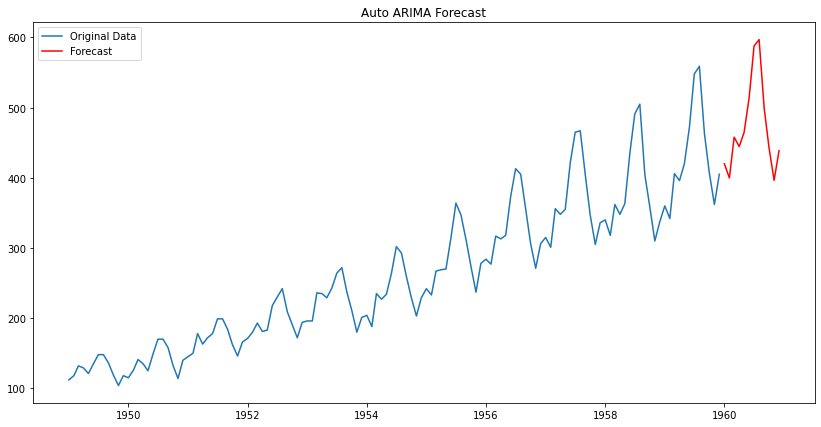

In [16]:
ts_data_auto = pd.concat([train, forecasts])

plt.figure(figsize=(14, 7))
plt.plot(ts_data_auto[:132], label='Original Data')
plt.plot(ts_data_auto[132:], color='red', label='Forecast')
plt.title('Auto ARIMA Forecast')
plt.legend()
plt.show()

In [17]:
mse = mean_squared_error(test, forecasts)
rmse = sqrt(mse)
rmse

18.53646895322675

Not only does the forecast from the autoarima look significantly better than the normal arima model, but the RMSE is also significantly lower as well. The difference is that this model essentailly incorporates a second ARIMA model, but for the seasonal component. This allows us to model how past seasonal patterns can influence current values. We also get a much better prediction on the ARIMA part (first set of parameters) as well. 